# Animal Classification in Images

# **Cấu hình chung**

In [2]:
import os, sys, glob, random, shutil, json, time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import joblib
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                                f1_score, classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Image Processing
from skimage.feature import hog
from skimage import exposure

# Deep Learning
import torch
import torch.nn as nn
from torchvision import models, transforms

In [3]:
# Random Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

# Đường dẫn lưu trữ local
BASE_PATH = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT = os.path.dirname(BASE_PATH)
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "data", "afhq_split_80_20")


print(f"Project Root: {PROJECT_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

Device: cpu
Project Root: f:\University of information technology's Courses\ComputerVision\Animal-Classification
Output directory: f:\University of information technology's Courses\ComputerVision\Animal-Classification\data\afhq_split_80_20


## **Kiểm tra Models đã được Train**
> Nếu models đã tồn tại, sẽ tự động load thay vì train lại

In [3]:
# Kiểm tra xem đã có models được train chưa
MODELS_DIR = "models"
DATA_DIR = "data/processed"

def check_trained_models():
    """Kiểm tra xem tất cả models đã được train và lưu chưa"""
    required_files = [
        'models/rf_handcrafted.pkl',
        'models/svm_handcrafted.pkl',
        'models/rf_deep.pkl',
        'models/svm_deep.pkl',
        'models/scaler_handcrafted.pkl',
        'models/scaler_deep.pkl',
        'data/processed/config.json',
        'data/processed/labels.json',
        'data/processed/X_train_hand.npy',
        'data/processed/X_test_hand.npy',
        'data/processed/y_train_hand.npy',
        'data/processed/y_test_hand.npy',
        'data/processed/X_train_deep.npy',
        'data/processed/X_test_deep.npy',
        'data/processed/y_train_deep.npy',
        'data/processed/y_test_deep.npy'
    ]
    
    all_exist = all(os.path.exists(f) for f in required_files)
    
    if all_exist:
        print("✓ Tất cả models và data đã được train và lưu!")
        print("  → Có thể LOAD trực tiếp thay vì train lại")
        print("  → Backend API có thể sử dụng ngay")
    else:
        print("⚠ Một số models chưa tồn tại, cần train:")
        for f in required_files:
            if not os.path.exists(f):
                print(f"  ✗ {f}")
    
    return all_exist

MODELS_EXIST = check_trained_models()

✓ Tất cả models và data đã được train và lưu!
  → Có thể LOAD trực tiếp thay vì train lại
  → Backend API có thể sử dụng ngay


In [4]:
# Cấu hình Handcrafted Features
IMG_SIZE_HOG = (128, 128)
HOG_ORIENTATIONS = 9
HOG_PIX_PER_CELL = (8, 8)
HOG_CELL_PER_BLOCK = (2, 2)
RGB_BINS = 16

# Cấu hình PCA
USE_PCA = True
PCA_COMPONENTS = 512

CV_FOLDS = 3

# **Download Dataset( animal )**

In [5]:
# Tải dataset
base_dir = os.path.join(PROJECT_ROOT, 'data', 'afhq-raw')
print(f"Thư mục dữ liệu gốc (Raw Data): {base_dir}")


# Kiểm tra thư mục tồn tại    print(f"✓ Thư mục dataset tồn tại!")

if not os.path.exists(base_dir):
    print(f"Cảnh báo: Thư mục {base_dir} không tồn tại!")    
else:
    print(f"Vui lòng tải dataset và đặt vào thư mục: {base_dir}")

Thư mục dữ liệu gốc (Raw Data): f:\University of information technology's Courses\ComputerVision\Animal-Classification\data\afhq-raw
Vui lòng tải dataset và đặt vào thư mục: f:\University of information technology's Courses\ComputerVision\Animal-Classification\data\afhq-raw


# **EDA Dataset**


> **Danh sách các lớp**

In [6]:
classes = sorted([d for d in os.listdir(base_dir)
                 if os.path.isdir(os.path.join(base_dir, d))])
print(f"Các lớp: {classes}")

Các lớp: ['cat', 'dog', 'wild']


> **Thống kê số lượng ảnh**

In [7]:
counts = []
for cname in classes:
    cpath = os.path.join(base_dir, cname)
    # Đếm số file ảnh
    num = len([f for f in os.listdir(cpath) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    counts.append((cname, num))

counts_df = pd.DataFrame(counts, columns=["Class","Count"])
display(counts_df)

Class  Count
0   cat   5558
1   dog   5169
2  wild   5076

C:\Users\tranh\AppData\Local\Temp\ipykernel_24708\3482783767.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_df, y="Class", x="Count", palette="viridis")


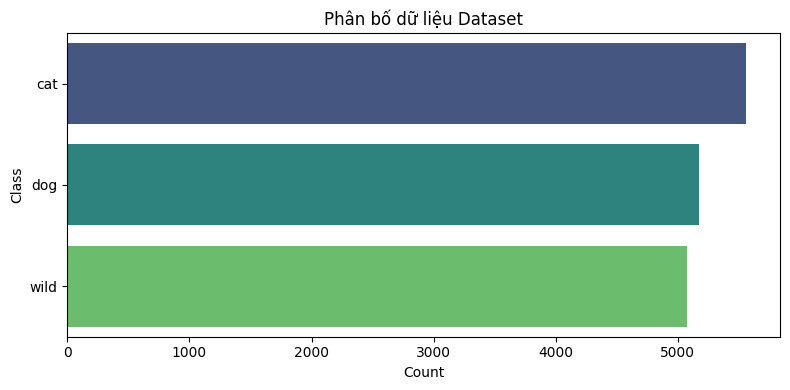

In [8]:
counts_df = pd.DataFrame(counts, columns=["Class", "Count"])
plt.figure(figsize=(8, 4))
sns.barplot(data=counts_df, y="Class", x="Count", palette="viridis")
plt.title("Phân bố dữ liệu Dataset")
plt.tight_layout()
plt.show()

> **Hiển thị lưới ảnh (mỗi lớp 1 ảnh)**

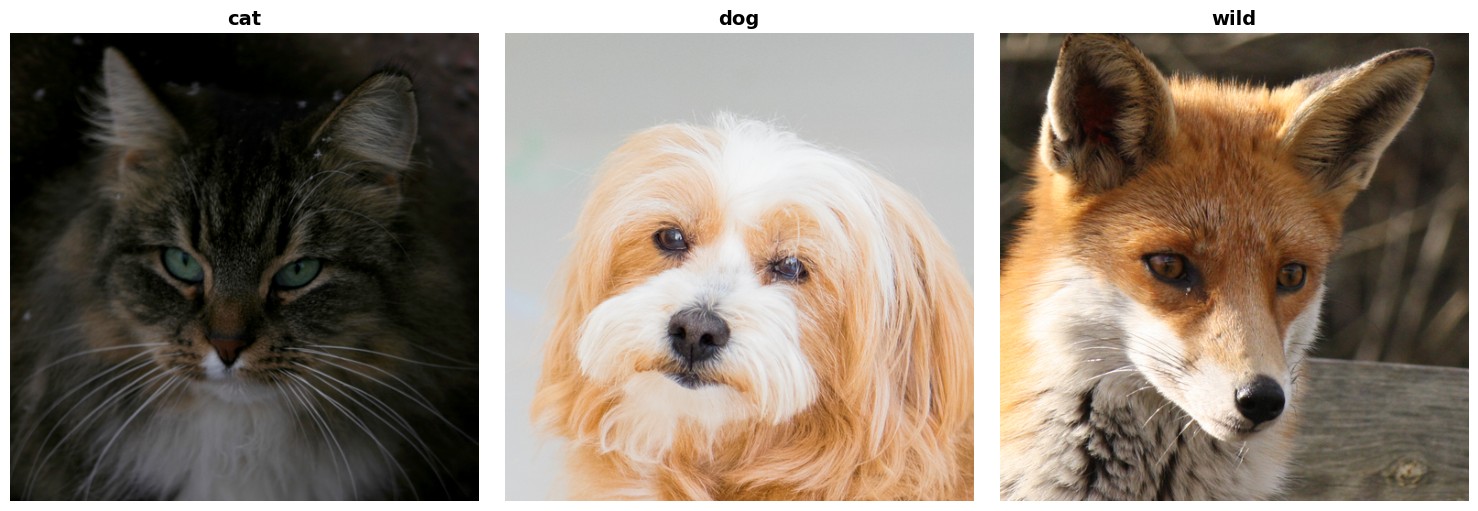

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png'))]
    if imgs:
        img = Image.open(os.path.join(cls_path, imgs[0])).convert('RGB')
        axes[i].imshow(img)
        axes[i].set_title(cls, fontsize=14, fontweight='bold')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

> **Phân tích sâu lớp 'Wild' (Vấn đề đa dạng nội lớp)**

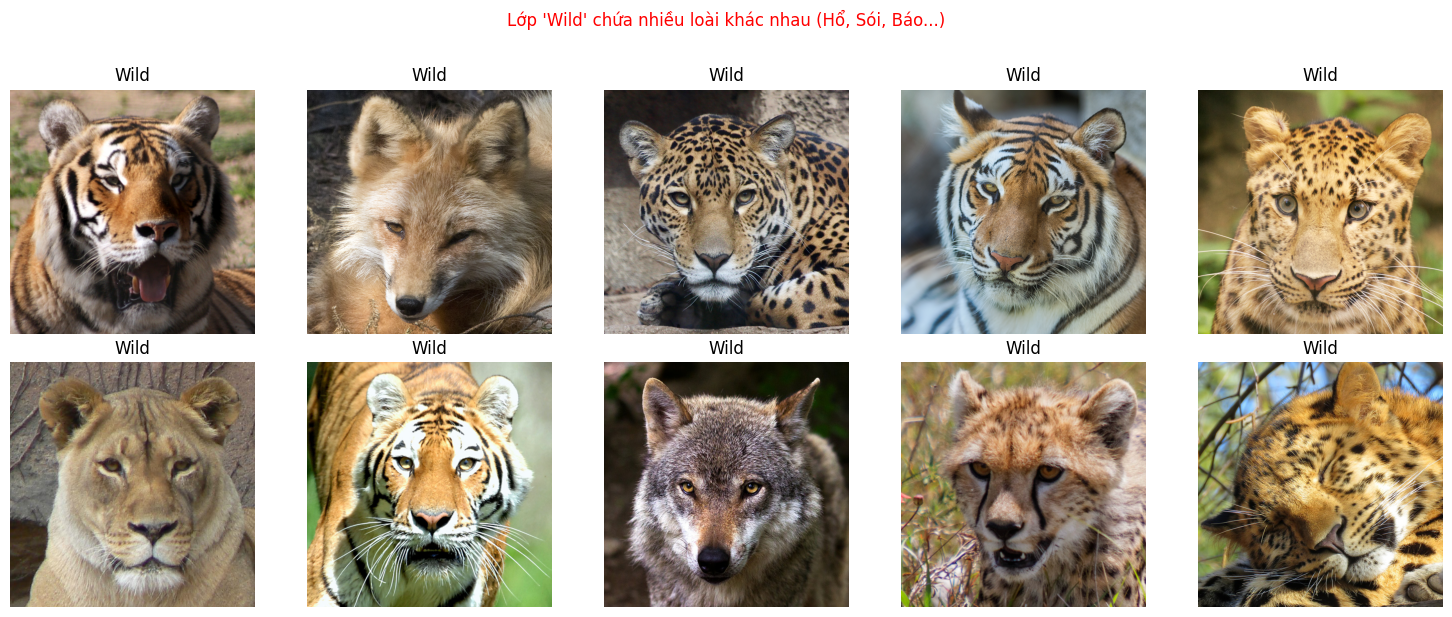

Nhận xét: Sự đa dạng loài trong lớp 'wild' cao hơn hẳn so với 'cat' hay 'dog'.


In [10]:
wild_dir = os.path.join(base_dir, 'wild')
if os.path.exists(wild_dir):
    wild_files = [f for f in os.listdir(wild_dir) if f.lower().endswith(('.jpg','.png'))]
    # Lấy ngẫu nhiên 10 ảnh để minh họa
    wild_samples = random.sample(wild_files, min(10, len(wild_files)))

    plt.figure(figsize=(15, 6))
    for i, img_name in enumerate(wild_samples):
        img_path = os.path.join(wild_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Wild")
    plt.suptitle("Lớp 'Wild' chứa nhiều loài khác nhau (Hổ, Sói, Báo...)", y=1.02, color='red')
    plt.tight_layout()
    plt.show()
    print("Nhận xét: Sự đa dạng loài trong lớp 'wild' cao hơn hẳn so với 'cat' hay 'dog'.")

# **CHIA DỮ LIỆU (TRAIN/TEST SPLIT)**

In [11]:
TRAIN_DIR = f"{OUTPUT_DIR}/train"
TEST_DIR = f"{OUTPUT_DIR}/test"

In [12]:
if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
    print("Dataset đã được chia trước đó. Skip.")
else:
    print("Đang chia dataset...")
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        train_files, test_files = train_test_split(files, test_size=0.2,
                                                   random_state=SEED)

        # Copy vào thư mục train
        train_cls_dir = os.path.join(TRAIN_DIR, cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        for f in train_files:
            shutil.copy(f, train_cls_dir)

        # Copy vào thư mục test
        test_cls_dir = os.path.join(TEST_DIR, cls)
        os.makedirs(test_cls_dir, exist_ok=True)
        for f in test_files:
            shutil.copy(f, test_cls_dir)

        print(f"  {cls}: Train={len(train_files)}, Test={len(test_files)}")

Đang chia dataset...
  cat: Train=4446, Test=1112
  cat: Train=4446, Test=1112
  dog: Train=4135, Test=1034
  dog: Train=4135, Test=1034
  wild: Train=4060, Test=1016
  wild: Train=4060, Test=1016


> **Lấy labels**

In [13]:
labels = sorted([d for d in os.listdir(TRAIN_DIR)
                if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"\nLabels: {labels}")


Labels: ['cat', 'dog', 'wild']


In [14]:
# Tạo thư mục lưu models và data
MODELS_DIR = "models"
DATA_DIR = "data/processed"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Lưu labels
labels_path = os.path.join(DATA_DIR, "labels.json")
with open(labels_path, 'w', encoding='utf-8') as f:
    json.dump(labels, f, ensure_ascii=False, indent=2)
print(f"✓ Đã lưu labels vào: {labels_path}")
# **LƯU THÔNG TIN LABELS**

✓ Đã lưu labels vào: data/processed\labels.json


# **MINH HỌA PHƯƠNG PHÁP TRÍCH XUẤT ĐẶC TRƯNG**

> **Lấy 1 ảnh mẫu**

In [15]:
sample_cls = classes[0]
sample_dir = os.path.join(TRAIN_DIR, sample_cls)
sample_imgs = [f for f in os.listdir(sample_dir) if f.endswith(('.jpg', '.png'))]
sample_img_path = os.path.join(sample_dir, sample_imgs[0])

print(f"Ảnh mẫu: {sample_img_path}")


Ảnh mẫu: f:\University of information technology's Courses\ComputerVision\Animal-Classification\data\afhq_split_80_20/train\cat\0000.png


## Minh họa Handcrafted Features (HOG + Color Histogram)

In [16]:
img_bgr = cv2.imread(sample_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_bgr, IMG_SIZE_HOG)
gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

# HOG
hog_feat, hog_img = hog(gray, orientations=HOG_ORIENTATIONS,
                        pixels_per_cell=HOG_PIX_PER_CELL,
                        cells_per_block=HOG_CELL_PER_BLOCK,
                        block_norm='L2-Hys', visualize=True)
hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))


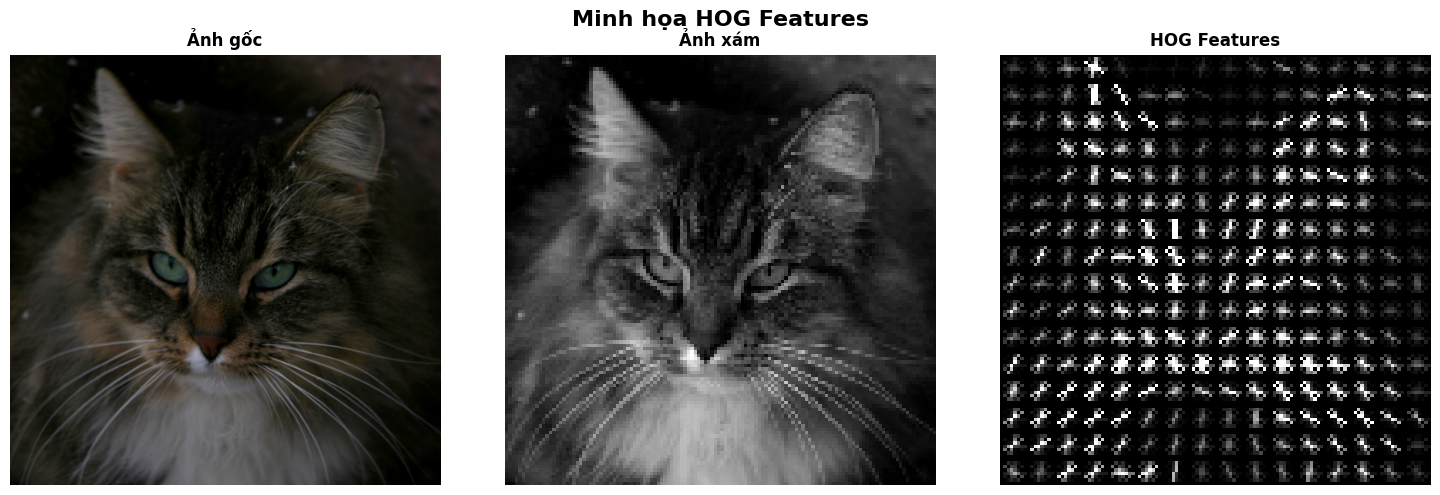

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("Ảnh gốc", fontweight='bold')
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Ảnh xám", fontweight='bold')
axes[1].axis('off')

axes[2].imshow(hog_img_rescaled, cmap='gray')
axes[2].set_title("HOG Features", fontweight='bold')
axes[2].axis('off')

plt.suptitle("Minh họa HOG Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

> **Histogram RGB của ảnh**

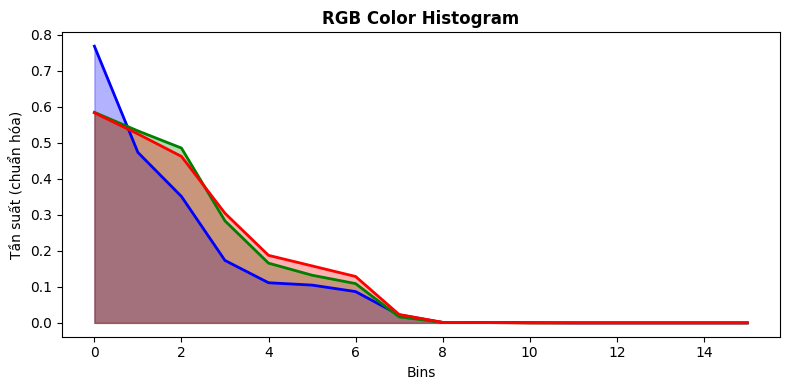

In [18]:
channels = cv2.split(img_resized)
colors = ('b', 'g', 'r')
plt.figure(figsize=(8, 4))
for ch, color in zip(channels, colors):
    hist = cv2.calcHist([ch], [0], None, [RGB_BINS], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    plt.plot(hist, color=color, linewidth=2)
    plt.fill_between(range(RGB_BINS), hist, color=color, alpha=0.3)
plt.title("RGB Color Histogram", fontweight='bold')
plt.xlabel("Bins")
plt.ylabel("Tần suất (chuẩn hóa)")
plt.tight_layout()
plt.show()

## **Minh họa Deep Learning Features (ResNet50)**

In [19]:
print("Loading ResNet50")
resnet_weights = models.ResNet50_Weights.IMAGENET1K_V1
resnet_model = models.resnet50(weights=resnet_weights)
resnet_model.fc = nn.Identity()  # Remove classifier
resnet_model.to(DEVICE)
resnet_model.eval()
resnet_transform = resnet_weights.transforms()

Loading ResNet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\tranh/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\tranh/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:09<00:00, 10.5MB/s]



> **Minh họa preprocessing**

In [20]:
img_pil = Image.open(sample_img_path).convert('RGB')
img_tensor = resnet_transform(img_pil)

In [21]:
# Denormalize để hiển thị
img_display = img_tensor.permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)

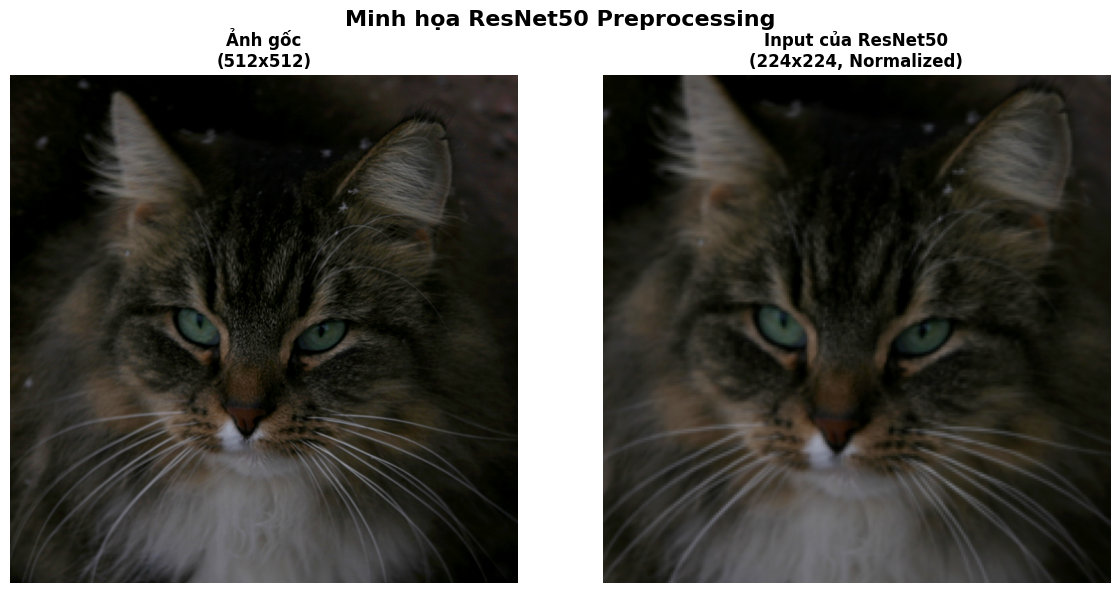

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_pil)
axes[0].set_title(f"Ảnh gốc\n({img_pil.size[0]}x{img_pil.size[1]})",
                 fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_display)
axes[1].set_title("Input của ResNet50\n(224x224, Normalized)",
                 fontweight='bold')
axes[1].axis('off')

plt.suptitle("Minh họa ResNet50 Preprocessing", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

> **Giải thích:**
- Bên trái: Ảnh gốc với kích thước và màu sắc tự nhiên.
- Bên phải: Những gì ResNet50 thực sự 'thấy'. Ảnh bị cắt lấy phần trung tâm (CenterCrop)
  và màu sắc được chuẩn hóa. ResNet sẽ trích xuất đặc trưng từ hình ảnh bên phải này.


# **TRÍCH XUẤT ĐẶC TRƯNG**

## **HOG + Color Histogram**

In [23]:
def extract_handcrafted(img_path):
    """Trích xuất HOG + Color Histogram từ 1 ảnh"""
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Resize
    img_resized = cv2.resize(img, IMG_SIZE_HOG)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # HOG
    hog_feat = hog(gray, orientations=HOG_ORIENTATIONS,
                  pixels_per_cell=HOG_PIX_PER_CELL,
                  cells_per_block=HOG_CELL_PER_BLOCK,
                  block_norm='L2-Hys')

    # Color Histogram
    color_feat = []
    for channel in cv2.split(img_resized):
        hist = cv2.calcHist([channel], [0], None, [RGB_BINS], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        color_feat.extend(hist)

    # Combine & normalize
    features = np.concatenate([hog_feat, np.array(color_feat, dtype=np.float32)])
    features = features / (np.linalg.norm(features) + 1e-8)

    return features

> **Trích xuất Train/Test set**

In [24]:
def extract_features(data_dir, labels, extractor_func, split_name="TRAIN"):
    print(f"\nExtracting {split_name} handcrafted features...")
    X, y = [], []

    for idx, label in enumerate(labels):
        class_dir = os.path.join(data_dir, label)
        files = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        for fname in files:
            feat = extractor_func(os.path.join(class_dir, fname))
            if feat is not None:
                X.append(feat)
                y.append(idx)

        print(f"  {label}: {len(files)} images")

    X = np.array(X)
    y = np.array(y)
    print(f" {split_name}: {X.shape}")
    return X, y

In [25]:
# Trích xuất Train set
X_train_hand, y_train_hand = extract_features(TRAIN_DIR, labels, extract_handcrafted, "TRAIN")

# Trích xuất Test set
X_test_hand, y_test_hand = extract_features(TEST_DIR, labels, extract_handcrafted, "TEST")



Extracting TRAIN handcrafted features...
  cat: 4446 images
  cat: 4446 images
  dog: 4135 images
  dog: 4135 images
  wild: 4060 images
  wild: 4060 images
 TRAIN: (12641, 8148)

Extracting TEST handcrafted features...
 TRAIN: (12641, 8148)

Extracting TEST handcrafted features...
  cat: 1112 images
  cat: 1112 images
  dog: 1034 images
  dog: 1034 images
  wild: 1016 images
 TEST: (3162, 8148)
  wild: 1016 images
 TEST: (3162, 8148)


In [26]:
# Lưu đặc trưng handcrafted
np.save(os.path.join(DATA_DIR, "X_train_hand.npy"), X_train_hand)
np.save(os.path.join(DATA_DIR, "y_train_hand.npy"), y_train_hand)
np.save(os.path.join(DATA_DIR, "X_test_hand.npy"), X_test_hand)
np.save(os.path.join(DATA_DIR, "y_test_hand.npy"), y_test_hand)
print(f"✓ Đã lưu đặc trưng Handcrafted vào: {DATA_DIR}")

✓ Đã lưu đặc trưng Handcrafted vào: data/processed


> **Lưu đặc trưng Handcrafted**

## **ResNet50**

In [27]:
def extract_deep(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = resnet_transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        features = resnet_model(img_tensor)

    return features.cpu().flatten().numpy()

In [28]:
def extract_features(data_dir, labels, extractor_func, split_name="TRAIN"):
    print(f"\n Extracting {split_name} deep features...")
    X, y = [], []

    for idx, label in enumerate(labels):
        class_dir = os.path.join(data_dir, label)
        files = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        for fname in files:
            feat = extractor_func(os.path.join(class_dir, fname))
            if feat is not None:
                X.append(feat)
                y.append(idx)

        print(f"  ✓ {label}: {len(files)} images")

    X = np.array(X)
    y = np.array(y)
    print(f" {split_name}: {X.shape}")
    return X, y


In [29]:
# Trích xuất Train set
X_train_deep, y_train_deep = extract_features(TRAIN_DIR, labels, extract_deep, "TRAIN")

# Trích xuất Test set
X_test_deep, y_test_deep = extract_features(TEST_DIR, labels, extract_deep, "TEST")


 Extracting TRAIN deep features...
  ✓ cat: 4446 images
  ✓ cat: 4446 images
  ✓ dog: 4135 images
  ✓ dog: 4135 images
  ✓ wild: 4060 images
 TRAIN: (12641, 2048)

 Extracting TEST deep features...
  ✓ wild: 4060 images
 TRAIN: (12641, 2048)

 Extracting TEST deep features...
  ✓ cat: 1112 images
  ✓ cat: 1112 images
  ✓ dog: 1034 images
  ✓ dog: 1034 images
  ✓ wild: 1016 images
 TEST: (3162, 2048)
  ✓ wild: 1016 images
 TEST: (3162, 2048)


In [30]:
# Lưu đặc trưng deep learning
np.save(os.path.join(DATA_DIR, "X_train_deep.npy"), X_train_deep)
np.save(os.path.join(DATA_DIR, "y_train_deep.npy"), y_train_deep)
np.save(os.path.join(DATA_DIR, "X_test_deep.npy"), X_test_deep)
np.save(os.path.join(DATA_DIR, "y_test_deep.npy"), y_test_deep)
print(f"✓ Đã lưu đặc trưng Deep Learning vào: {DATA_DIR}")

✓ Đã lưu đặc trưng Deep Learning vào: data/processed


> **Lưu đặc trưng Deep Learning**

# **PREPROCESSING: STANDARDSCALER + PCA**

> **Cho HOG + Color Hist**

In [31]:
scaler_hand = StandardScaler()
X_train_hand_scaled = scaler_hand.fit_transform(X_train_hand)
X_test_hand_scaled = scaler_hand.transform(X_test_hand)

if USE_PCA and X_train_hand.shape[1] > PCA_COMPONENTS:
    print(f"Applying PCA: {X_train_hand.shape[1]} → {PCA_COMPONENTS}")
    pca_hand = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
    X_train_hand_final = pca_hand.fit_transform(X_train_hand_scaled)
    X_test_hand_final = pca_hand.transform(X_test_hand_scaled)
    print(f"Explained variance: {pca_hand.explained_variance_ratio_.sum():.2%}")
else:
    pca_hand = None
    X_train_hand_final = X_train_hand_scaled
    X_test_hand_final = X_test_hand_scaled

print(f"Handcrafted final shape: Train{X_train_hand_final.shape}, Test{X_test_hand_final.shape}")


Applying PCA: 8148 → 512
Explained variance: 64.21%
Handcrafted final shape: Train(12641, 512), Test(3162, 512)
Explained variance: 64.21%
Handcrafted final shape: Train(12641, 512), Test(3162, 512)


In [32]:
# Lưu Scaler và PCA cho Handcrafted
joblib.dump(scaler_hand, os.path.join(MODELS_DIR, "scaler_handcrafted.pkl"))
if pca_hand:
    joblib.dump(pca_hand, os.path.join(MODELS_DIR, "pca_handcrafted.pkl"))
print(f"✓ Đã lưu Scaler và PCA (Handcrafted) vào: {MODELS_DIR}")

✓ Đã lưu Scaler và PCA (Handcrafted) vào: models


> **Lưu Scaler và PCA cho Handcrafted**

> **Cho Resnet50**

In [33]:
scaler_deep = StandardScaler()
X_train_deep_scaled = scaler_deep.fit_transform(X_train_deep)
X_test_deep_scaled = scaler_deep.transform(X_test_deep)

if USE_PCA and X_train_deep.shape[1] > PCA_COMPONENTS:
    print(f"  Applying PCA: {X_train_deep.shape[1]} → {PCA_COMPONENTS}")
    pca_deep = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
    X_train_deep_final = pca_deep.fit_transform(X_train_deep_scaled)
    X_test_deep_final = pca_deep.transform(X_test_deep_scaled)
    print(f"  Explained variance: {pca_deep.explained_variance_ratio_.sum():.2%}")
else:
    pca_deep = None
    X_train_deep_final = X_train_deep_scaled
    X_test_deep_final = X_test_deep_scaled

print(f"Deep final shape: Train{X_train_deep_final.shape}, Test{X_test_deep_final.shape}")


  Applying PCA: 2048 → 512
  Explained variance: 97.47%
Deep final shape: Train(12641, 512), Test(3162, 512)
  Explained variance: 97.47%
Deep final shape: Train(12641, 512), Test(3162, 512)


In [34]:
# Lưu Scaler và PCA cho Deep Learning
joblib.dump(scaler_deep, os.path.join(MODELS_DIR, "scaler_deep.pkl"))
if pca_deep:
    joblib.dump(pca_deep, os.path.join(MODELS_DIR, "pca_deep.pkl"))
print(f"✓ Đã lưu Scaler và PCA (Deep Learning) vào: {MODELS_DIR}")

✓ Đã lưu Scaler và PCA (Deep Learning) vào: models


> **Lưu Scaler và PCA cho Deep Learning**

# **TRAINING MODELS**

In [35]:
def evaluate_and_print(model_name, y_true, y_pred, labels):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("CONFUSION MATRIX:")
    print(cm)
    print()

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Classification report
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))

    # Vẽ confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## **Sử dụng đặc trưng của HOG + Color Histogram**


### **Model Random Forest (FR)**


In [36]:
rf_hand = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=500,
    max_depth=25,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1
)

In [37]:
rf_hand.fit(X_train_hand_final, y_train_hand)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [38]:
# Lưu model
model_path = os.path.join(MODELS_DIR, "rf_handcrafted.pkl")
joblib.dump(rf_hand, model_path)
print(f"✓ Đã lưu Random Forest (Handcrafted) vào: {model_path}")

✓ Đã lưu Random Forest (Handcrafted) vào: models\rf_handcrafted.pkl


> **Lưu model Random Forest (Handcrafted)**

> **Đánh giá mô hình RF tốt nhất trên tập test**


Đánh giá Random Forest trên tập TEST 
CONFUSION MATRIX:
[[1026   58   28]
 [  48  881  105]
 [ 102   90  824]]

Accuracy: 0.8637

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     0.8724    0.9227    0.8969      1112
         dog     0.8562    0.8520    0.8541      1034
        wild     0.8610    0.8110    0.8353      1016

    accuracy                         0.8637      3162
   macro avg     0.8632    0.8619    0.8621      3162
weighted avg     0.8635    0.8637    0.8631      3162

CONFUSION MATRIX:
[[1026   58   28]
 [  48  881  105]
 [ 102   90  824]]

Accuracy: 0.8637

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     0.8724    0.9227    0.8969      1112
         dog     0.8562    0.8520    0.8541      1034
        wild     0.8610    0.8110    0.8353      1016

    accuracy                         0.8637      3162
   macro avg     0.8632    0.8619    0.8621      3162
weighted avg     0.8635 

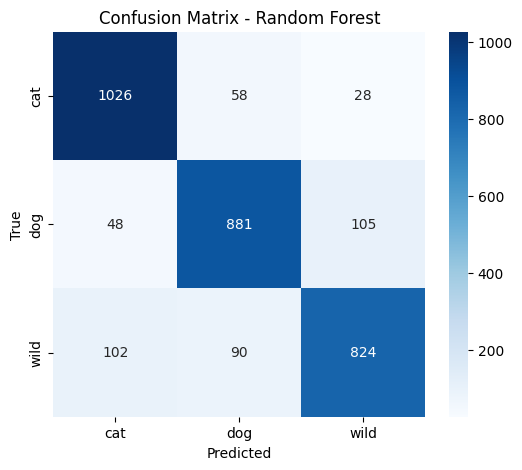

In [39]:
print("\nĐánh giá Random Forest trên tập TEST ")
y_pred_rf = rf_hand.predict(X_test_hand_final)
evaluate_and_print("Random Forest", y_test_hand, y_pred_rf, labels)

### **SVM**

In [40]:
svm_hand = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=SEED
               )

In [41]:
svm_hand.fit(X_train_hand_final, y_train_hand)

SVC(C=10, class_weight='balanced', probability=True, random_state=42)

In [42]:
# Lưu model
model_path = os.path.join(MODELS_DIR, "svm_handcrafted.pkl")
joblib.dump(svm_hand, model_path)
print(f"✓ Đã lưu SVM (Handcrafted) vào: {model_path}")

✓ Đã lưu SVM (Handcrafted) vào: models\svm_handcrafted.pkl


> **Lưu model SVM (Handcrafted)**

> **Đánh giá mô hình SVM trên tập TEST**


Đánh giá SVM (Tuned RBF) trên tập TEST 
CONFUSION MATRIX:
[[1079   17   16]
 [  16  950   68]
 [  16   42  958]]

Accuracy: 0.9447

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     0.9712    0.9703    0.9708      1112
         dog     0.9415    0.9188    0.9300      1034
        wild     0.9194    0.9429    0.9310      1016

    accuracy                         0.9447      3162
   macro avg     0.9440    0.9440    0.9439      3162
weighted avg     0.9448    0.9447    0.9447      3162

CONFUSION MATRIX:
[[1079   17   16]
 [  16  950   68]
 [  16   42  958]]

Accuracy: 0.9447

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     0.9712    0.9703    0.9708      1112
         dog     0.9415    0.9188    0.9300      1034
        wild     0.9194    0.9429    0.9310      1016

    accuracy                         0.9447      3162
   macro avg     0.9440    0.9440    0.9439      3162
weighted avg     0.944

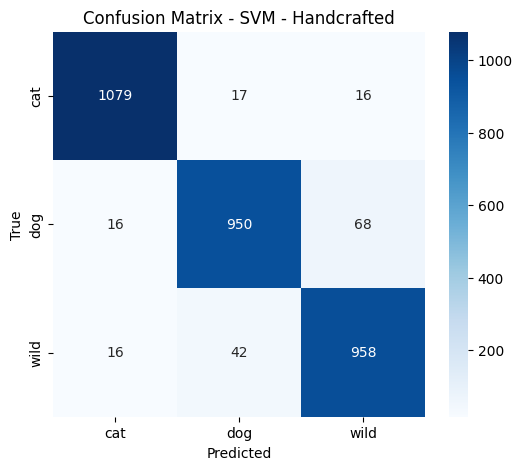

In [43]:
print("\nĐánh giá SVM (Tuned RBF) trên tập TEST ")
y_pred_svm_hand = svm_hand.predict(X_test_hand_final)
evaluate_and_print("SVM - Handcrafted", y_test_hand, y_pred_svm_hand, labels)

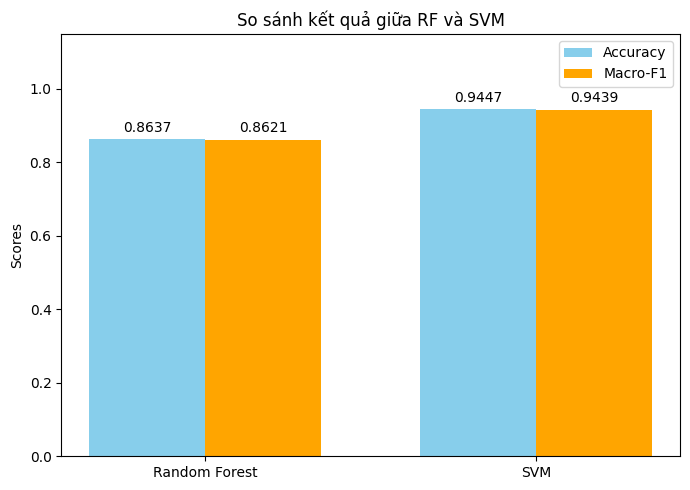

In [44]:
rf_acc = accuracy_score(y_test_hand, y_pred_rf)
rf_f1 = f1_score(y_test_hand, y_pred_rf, average='macro')
svm_acc = accuracy_score(y_test_hand, y_pred_svm_hand)
svm_f1 = f1_score(y_test_hand, y_pred_svm_hand, average='macro')

models = ["Random Forest", "SVM"]
accs = [rf_acc, svm_acc]
f1s  = [rf_f1, svm_f1]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

rects1 = ax.bar(x - width/2, accs, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1s,  width, label='Macro-F1', color='orange')

ax.set_ylabel('Scores')
ax.set_title('So sánh kết quả giữa RF và SVM')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.15)
plt.tight_layout()
plt.show()

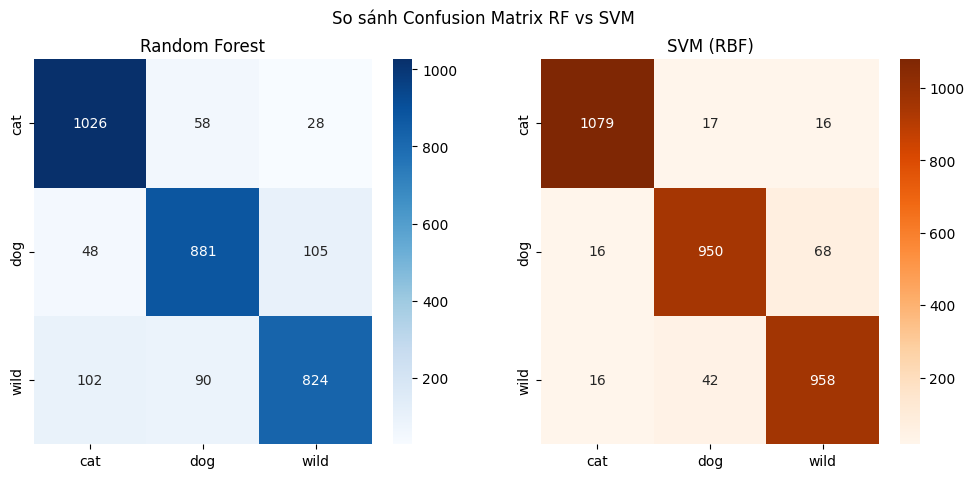

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test_hand, y_pred_rf), annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes, ax=axs[0])
axs[0].set_title("Random Forest")

sns.heatmap(confusion_matrix(y_test_hand, y_pred_svm_hand), annot=True, fmt="d", cmap="Oranges",
            xticklabels=classes, yticklabels=classes, ax=axs[1])
axs[1].set_title("SVM (RBF)")

plt.suptitle("So sánh Confusion Matrix RF vs SVM")
plt.show()

## **Sử dụng đặc trưng từ Resnet50**

### **Ramdom Forest (RF)**

In [46]:
rf_deep = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=500,
    max_depth=25,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1
)

In [47]:
rf_deep.fit(X_train_deep_final, y_train_deep)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [48]:
# Lưu model
model_path = os.path.join(MODELS_DIR, "rf_deep.pkl")
joblib.dump(rf_deep, model_path)
print(f"✓ Đã lưu Random Forest (Deep) vào: {model_path}")

✓ Đã lưu Random Forest (Deep) vào: models\rf_deep.pkl


> **Lưu model Random Forest (Deep)**

> **Đánh giá mô hình RF trên tập TEST**


Đánh giá Random Forest trên tập TEST 
CONFUSION MATRIX:
[[1107    3    2]
 [   0 1033    1]
 [   0    6 1010]]

Accuracy: 0.9962

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     1.0000    0.9955    0.9977      1112
         dog     0.9914    0.9990    0.9952      1034
        wild     0.9970    0.9941    0.9956      1016

    accuracy                         0.9962      3162
   macro avg     0.9961    0.9962    0.9962      3162
weighted avg     0.9962    0.9962    0.9962      3162

CONFUSION MATRIX:
[[1107    3    2]
 [   0 1033    1]
 [   0    6 1010]]

Accuracy: 0.9962

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     1.0000    0.9955    0.9977      1112
         dog     0.9914    0.9990    0.9952      1034
        wild     0.9970    0.9941    0.9956      1016

    accuracy                         0.9962      3162
   macro avg     0.9961    0.9962    0.9962      3162
weighted avg     0.9962 

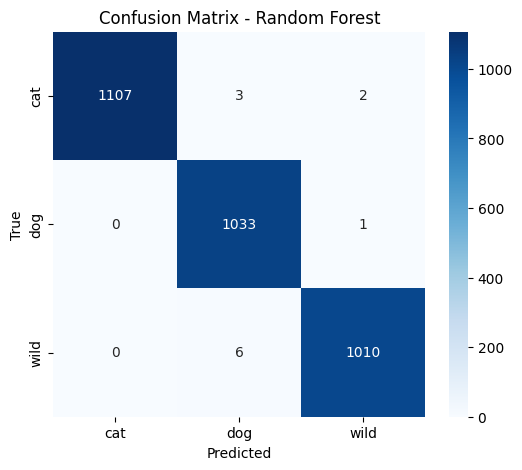

In [49]:
print("\nĐánh giá Random Forest trên tập TEST ")
y_pred_rf = rf_deep.predict(X_test_deep_final)
evaluate_and_print("Random Forest", y_test_deep, y_pred_rf, labels)

### **SVM**

In [50]:
svm_deep = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=SEED
)

In [51]:
svm_deep.fit(X_train_deep_final, y_train_deep)

SVC(C=10, class_weight='balanced', probability=True, random_state=42)

In [52]:
# Lưu model
model_path = os.path.join(MODELS_DIR, "svm_deep.pkl")
joblib.dump(svm_deep, model_path)
print(f"✓ Đã lưu SVM (Deep) vào: {model_path}")

✓ Đã lưu SVM (Deep) vào: models\svm_deep.pkl


> **Lưu model SVM (Deep)**

> **Đánh giá mô hình SVM trên tập TEST**


Đánh giá SVM trên tập TEST 
CONFUSION MATRIX:
[[1110    0    2]
 [   0 1032    2]
 [   0    4 1012]]

Accuracy: 0.9975

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     1.0000    0.9982    0.9991      1112
         dog     0.9961    0.9981    0.9971      1034
        wild     0.9961    0.9961    0.9961      1016

    accuracy                         0.9975      3162
   macro avg     0.9974    0.9974    0.9974      3162
weighted avg     0.9975    0.9975    0.9975      3162

CONFUSION MATRIX:
[[1110    0    2]
 [   0 1032    2]
 [   0    4 1012]]

Accuracy: 0.9975

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         cat     1.0000    0.9982    0.9991      1112
         dog     0.9961    0.9981    0.9971      1034
        wild     0.9961    0.9961    0.9961      1016

    accuracy                         0.9975      3162
   macro avg     0.9974    0.9974    0.9974      3162
weighted avg     0.9975    0.9975 

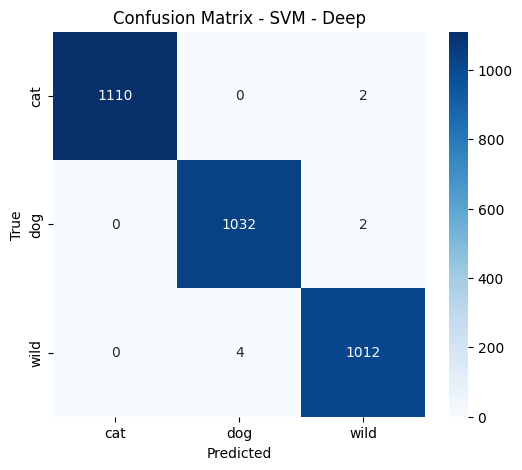

In [53]:
print("\nĐánh giá SVM trên tập TEST ")
y_pred_svm_deep = svm_deep.predict(X_test_deep_final)
evaluate_and_print("SVM - Deep", y_test_deep, y_pred_svm_deep, labels)

> **VẼ BIỂU ĐỒ SO SÁNH**


-> Vẽ biểu đồ so sánh kết quả (Deep Features)...


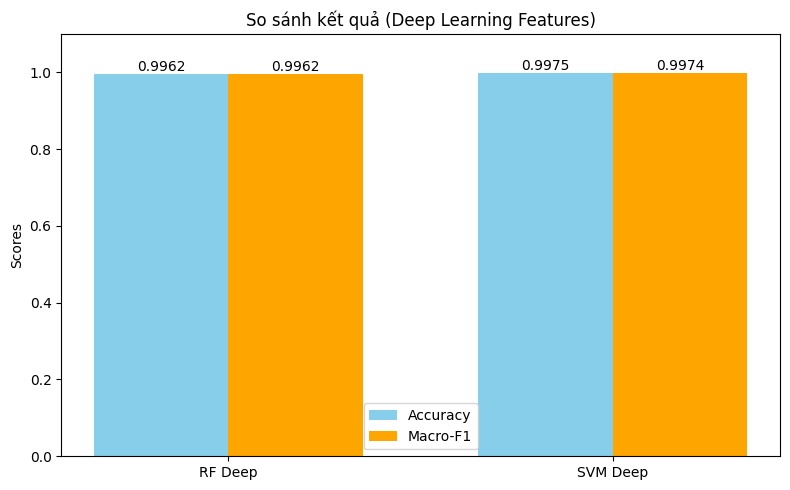

In [54]:
print("\n-> Vẽ biểu đồ so sánh kết quả (Deep Features)...")
models_name = ["RF Deep", "SVM Deep"]
accs = [accuracy_score(y_test_deep, y_pred_rf), accuracy_score(y_test_deep, y_pred_svm_deep)]
f1s  = [f1_score(y_test_deep, y_pred_rf, average='macro'), f1_score(y_test_deep, y_pred_svm_deep, average='macro')]

x = np.arange(len(models_name))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, accs, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1s,  width, label='Macro-F1', color='orange')

ax.set_ylabel('Scores')
ax.set_title('So sánh kết quả (Deep Learning Features)')
ax.set_xticks(x)
ax.set_xticklabels(models_name)
ax.legend()
ax.bar_label(rects1, fmt='%.4f')
ax.bar_label(rects2, fmt='%.4f')
plt.ylim(0,1.1)
plt.tight_layout()
plt.show()

# EVALUATION

In [55]:
# Dictionary lưu kết quả
results = {}

# Hàm đánh giá
def evaluate(model, X_test, y_test, name):
    """Đánh giá model và trả về kết quả"""
    y_pred = model.predict(X_test)

    res = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro': recall_score(y_test, y_pred, average='macro'),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred
    }

    print(f"Accuracy:     {res['accuracy']:.4f}")
    print(f"F1 Macro:     {res['f1_macro']:.4f}")
    print(f"F1 Weighted:  {res['f1_weighted']:.4f}")
    print(f"Precision:    {res['precision_macro']:.4f}")
    print(f"Recall:       {res['recall_macro']:.4f}")
    print(f"\nConfusion Matrix:")
    print(res['confusion_matrix'])
    print(f"\n{classification_report(y_test, y_pred, target_names=labels)}")

    return res

In [6]:
results['handcrafted_rf'] = evaluate(rf_hand, X_test_hand_final, y_test_hand,
"RF - Handcrafted")
results['handcrafted_svm'] = evaluate(svm_hand, X_test_hand_final, y_test_hand, "SVM - Handcrafted")
results['deep_rf'] = evaluate(rf_deep, X_test_deep_final, y_test_deep,
"RF - Deep Learning")
results['deep_svm'] = evaluate(svm_deep, X_test_deep_final, y_test_deep,
"SVM - Deep Learning")

NameError: name 'evaluate' is not defined

> **SO SÁNH & VISUALIZATION**

In [57]:
summary_data = []
for key, res in results.items():
    method, model = key.split('_')
    summary_data.append({
        'Feature': method.upper(),
        'Model': model.upper(),
        'Accuracy': f"{res['accuracy']:.4f}",
        'F1 Macro': f"{res['f1_macro']:.4f}",
        'F1 Weighted': f"{res['f1_weighted']:.4f}",
        'Precision': f"{res['precision_macro']:.4f}",
        'Recall': f"{res['recall_macro']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

    Feature Model Accuracy F1 Macro F1 Weighted Precision Recall
HANDCRAFTED    RF   0.8637   0.8621      0.8631    0.8632 0.8619
HANDCRAFTED   SVM   0.9447   0.9439      0.9447    0.9440 0.9440
       DEEP    RF   0.9962   0.9962      0.9962    0.9961 0.9962
       DEEP   SVM   0.9975   0.9974      0.9975    0.9974 0.9974


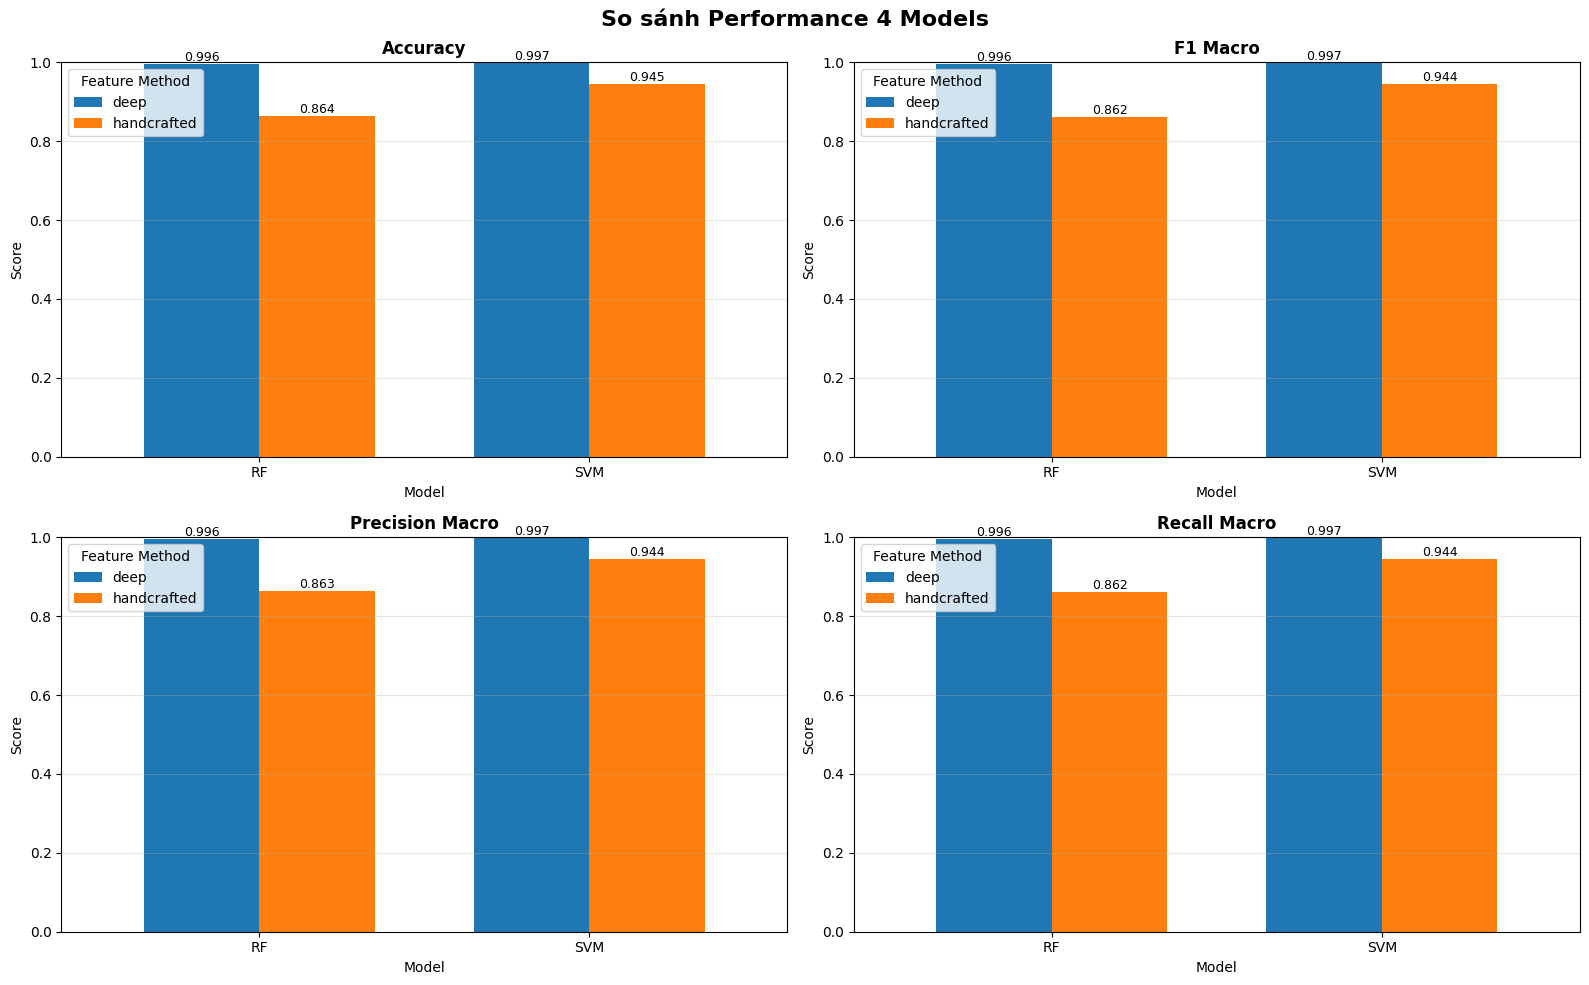

In [58]:
metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
data = []
for key, res in results.items():
    method, model = key.split('_')
    for metric in metrics:
        data.append({
            'Feature': method,
            'Model': model.upper(),
            'Metric': metric.replace('_', ' ').title(),
            'Score': res[metric]
        })

df = pd.DataFrame(data)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    metric_data = df[df['Metric'] == metric.replace('_', ' ').title()]
    pivot = metric_data.pivot(index='Model', columns='Feature', values='Score')
    pivot.plot(kind='bar', ax=axes[idx], width=0.7, rot=0)

    axes[idx].set_title(metric.replace('_', ' ').title(), fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Score')
    axes[idx].set_ylim([0, 1])
    axes[idx].legend(title='Feature Method')
    axes[idx].grid(axis='y', alpha=0.3)

    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.3f', fontsize=9)

plt.suptitle('So sánh Performance 4 Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

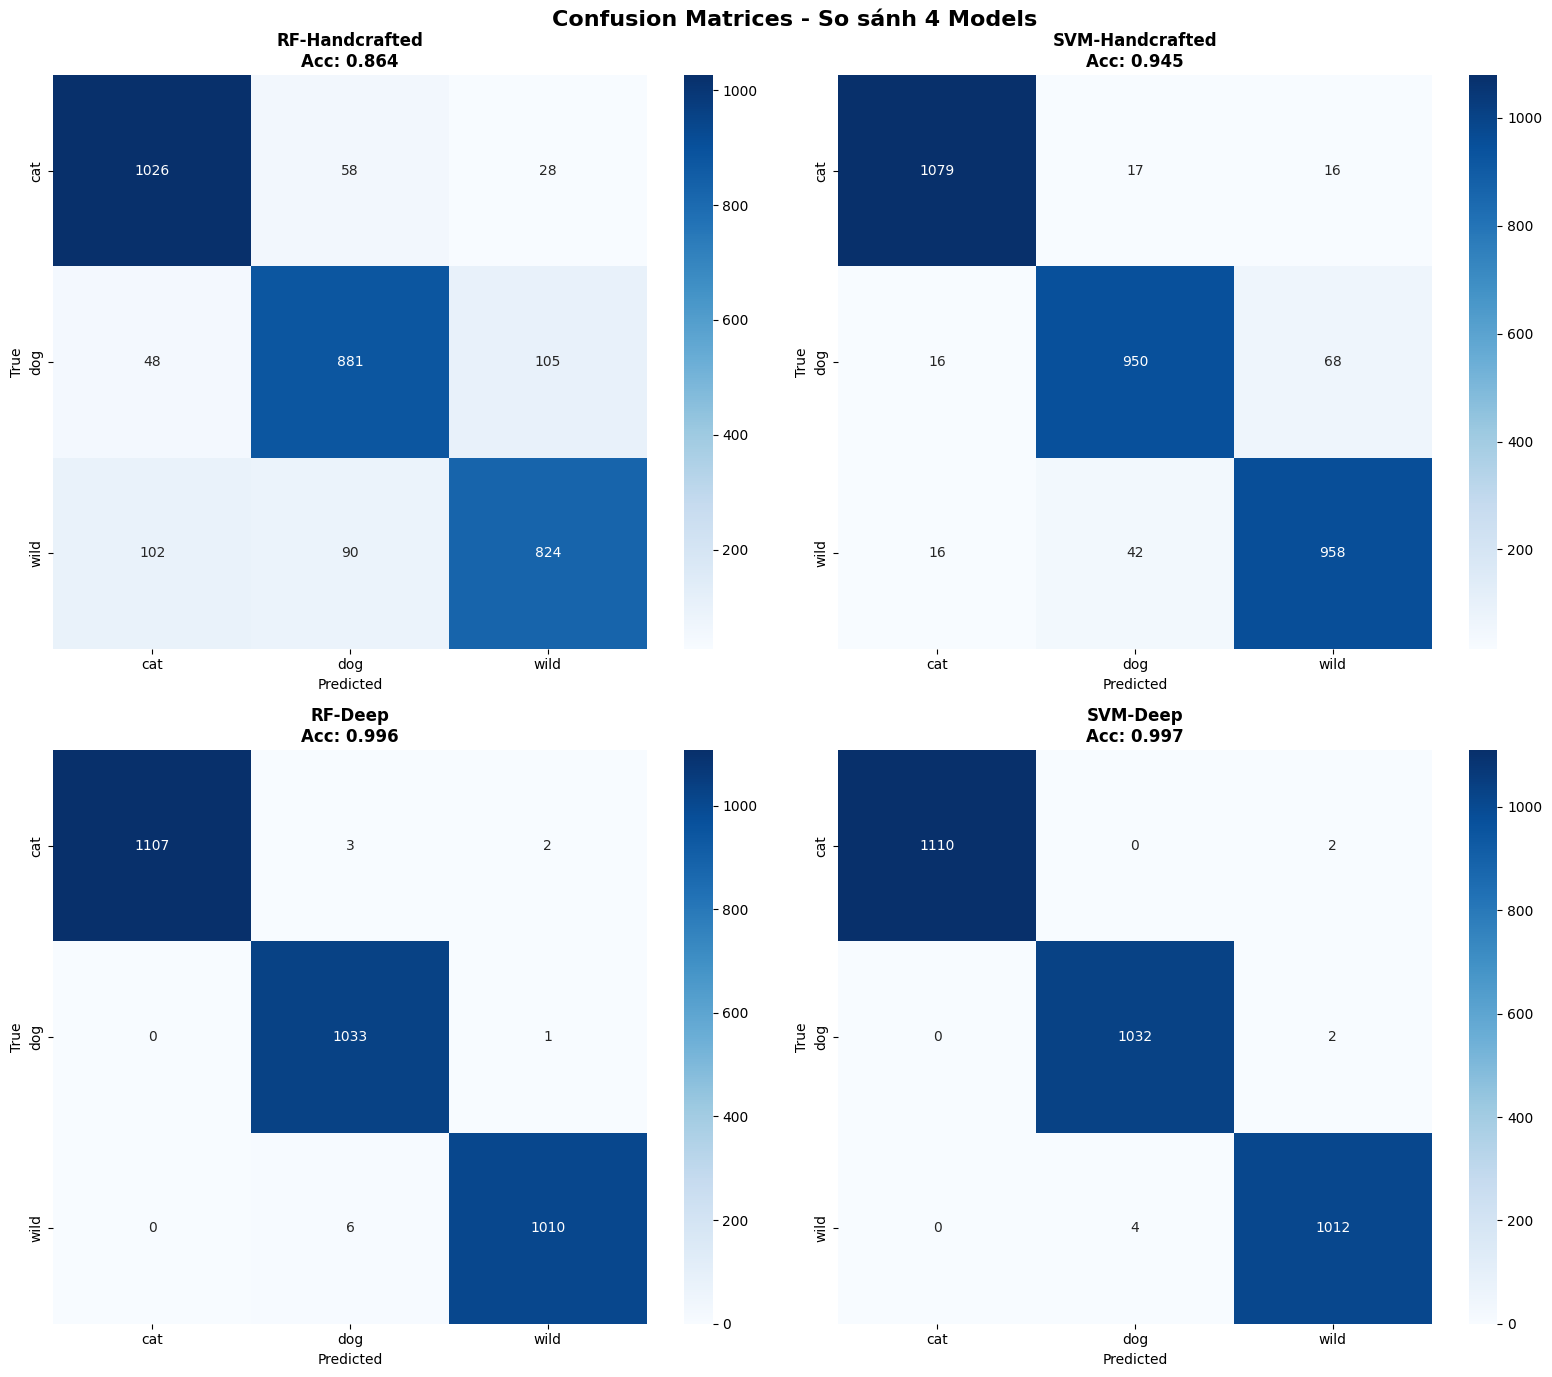

In [59]:
# Vẽ Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

titles = ['RF-Handcrafted', 'SVM-Handcrafted', 'RF-Deep', 'SVM-Deep']
for idx, (key, title) in enumerate(zip(results.keys(), titles)):
    cm = results[key]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels, yticklabels=labels, ax=axes[idx])
    axes[idx].set_title(f'{title}\nAcc: {results[key]["accuracy"]:.3f}',
                       fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.suptitle('Confusion Matrices - So sánh 4 Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **TỰ ĐỘNG LƯU KẾT QUẢ CHO FRONTEND**
> Cell này có thể chạy độc lập để cập nhật kết quả cho frontend

In [10]:
"""
Cell này tự động lưu kết quả training cho frontend.
Có thể chạy độc lập mà không cần chạy lại toàn bộ notebook.
"""
import os
import json
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix

# Paths
MODELS_DIR = "models"
DATA_DIR = "data/processed"

print("=" * 60)
print("TỰ ĐỘNG LƯU KẾT QUẢ TRAINING CHO FRONTEND")
print("=" * 60)

# Load labels
with open(os.path.join(DATA_DIR, 'labels.json'), 'r', encoding='utf-8') as f:
    labels = json.load(f)
print(f"\n✓ Labels: {labels}")

# Load models
print("\n📦 Loading models...")
rf_hand = joblib.load(os.path.join(MODELS_DIR, 'rf_handcrafted.pkl'))
svm_hand = joblib.load(os.path.join(MODELS_DIR, 'svm_handcrafted.pkl'))
rf_deep = joblib.load(os.path.join(MODELS_DIR, 'rf_deep.pkl'))
svm_deep = joblib.load(os.path.join(MODELS_DIR, 'svm_deep.pkl'))

scaler_hand = joblib.load(os.path.join(MODELS_DIR, 'scaler_handcrafted.pkl'))
scaler_deep = joblib.load(os.path.join(MODELS_DIR, 'scaler_deep.pkl'))

pca_hand_path = os.path.join(MODELS_DIR, 'pca_handcrafted.pkl')
pca_hand = joblib.load(pca_hand_path) if os.path.exists(pca_hand_path) else None

pca_deep_path = os.path.join(MODELS_DIR, 'pca_deep.pkl')
pca_deep = joblib.load(pca_deep_path) if os.path.exists(pca_deep_path) else None

print("✓ Models loaded!")

# Load test data
print("\n📊 Loading test data...")
X_test_hand = np.load(os.path.join(DATA_DIR, 'X_test_hand.npy'))
y_test_hand = np.load(os.path.join(DATA_DIR, 'y_test_hand.npy'))
X_test_deep = np.load(os.path.join(DATA_DIR, 'X_test_deep.npy'))
y_test_deep = np.load(os.path.join(DATA_DIR, 'y_test_deep.npy'))
print(f"✓ Test data loaded: {len(y_test_hand)} samples")

# Preprocess features
print("\n🔄 Preprocessing features...")
X_test_hand_scaled = scaler_hand.transform(X_test_hand)
X_test_hand_final = pca_hand.transform(X_test_hand_scaled) if pca_hand else X_test_hand_scaled

X_test_deep_scaled = scaler_deep.transform(X_test_deep)
X_test_deep_final = pca_deep.transform(X_test_deep_scaled) if pca_deep else X_test_deep_scaled

# Calculate predictions and accuracies
print("\n🎯 Calculating accuracies...")
y_pred_rf_hand = rf_hand.predict(X_test_hand_final)
y_pred_svm_hand = svm_hand.predict(X_test_hand_final)
y_pred_rf_deep = rf_deep.predict(X_test_deep_final)
y_pred_svm_deep = svm_deep.predict(X_test_deep_final)

acc_rf_hand = accuracy_score(y_test_hand, y_pred_rf_hand)
acc_svm_hand = accuracy_score(y_test_hand, y_pred_svm_hand)
acc_rf_deep = accuracy_score(y_test_deep, y_pred_rf_deep)
acc_svm_deep = accuracy_score(y_test_deep, y_pred_svm_deep)

print(f"  RF-Handcrafted:  {acc_rf_hand*100:.2f}%")
print(f"  SVM-Handcrafted: {acc_svm_hand*100:.2f}%")
print(f"  RF-Deep:         {acc_rf_deep*100:.2f}%")
print(f"  SVM-Deep:        {acc_svm_deep*100:.2f}%")

# Calculate confusion matrices
print("\n📊 Calculating confusion matrices...")
cm_rf_hand = confusion_matrix(y_test_hand, y_pred_rf_hand)
cm_svm_hand = confusion_matrix(y_test_hand, y_pred_svm_hand)
cm_rf_deep = confusion_matrix(y_test_deep, y_pred_rf_deep)
cm_svm_deep = confusion_matrix(y_test_deep, y_pred_svm_deep)

# Save training results JSON with confusion matrices data
training_results = {
    "models": [
        {
            "name": "RF-Handcrafted",
            "display_name": "RF-Handcrafted",
            "method": "handcrafted",
            "model_type": "rf",
            "accuracy": round(acc_rf_hand * 100, 2),
            "training_time": "~5 phút",
            "note": "Nhanh nhưng kém chính xác",
            "confusion_matrix": cm_rf_hand.tolist()
        },
        {
            "name": "SVM-Handcrafted",
            "display_name": "SVM-Handcrafted",
            "method": "handcrafted",
            "model_type": "svm",
            "accuracy": round(acc_svm_hand * 100, 2),
            "training_time": "~8 phút",
            "note": "Cân bằng tốc độ và độ chính xác",
            "confusion_matrix": cm_svm_hand.tolist()
        },
        {
            "name": "RF-Deep",
            "display_name": "RF-Deep",
            "method": "deep",
            "model_type": "rf",
            "accuracy": round(acc_rf_deep * 100, 2),
            "training_time": "~12 phút",
            "note": "Độ chính xác rất cao",
            "confusion_matrix": cm_rf_deep.tolist()
        },
        {
            "name": "SVM-Deep",
            "display_name": "SVM-Deep",
            "method": "deep",
            "model_type": "svm",
            "accuracy": round(acc_svm_deep * 100, 2),
            "training_time": "~15 phút",
            "note": "Best Model",
            "confusion_matrix": cm_svm_deep.tolist()
        }
    ],
    "labels": labels
}

results_path = os.path.join(DATA_DIR, 'training_results.json')
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(training_results, f, ensure_ascii=False, indent=2)

print(f"✓ Saved: {results_path}")

print("\n" + "=" * 60)
print("✅ HOÀN TẤT! Kết quả đã được lưu cho frontend")
print("=" * 60)
print("\nBây giờ reload trang web để thấy kết quả mới!")
print(f"\n📊 Confusion Matrices đã được lưu trong JSON")
print(f"   Frontend sẽ tự động vẽ bằng JavaScript")

TỰ ĐỘNG LƯU KẾT QUẢ TRAINING CHO FRONTEND

✓ Labels: ['cat', 'dog', 'wild']

📦 Loading models...
✓ Models loaded!

📊 Loading test data...
✓ Test data loaded: 3162 samples

🔄 Preprocessing features...
✓ Models loaded!

📊 Loading test data...
✓ Test data loaded: 3162 samples

🔄 Preprocessing features...

🎯 Calculating accuracies...

🎯 Calculating accuracies...
  RF-Handcrafted:  86.37%
  SVM-Handcrafted: 94.47%
  RF-Deep:         99.62%
  SVM-Deep:        99.75%

📊 Calculating confusion matrices...
✓ Saved: data/processed\training_results.json

✅ HOÀN TẤT! Kết quả đã được lưu cho frontend

Bây giờ reload trang web để thấy kết quả mới!

📊 Confusion Matrices đã được lưu trong JSON
   Frontend sẽ tự động vẽ bằng JavaScript
  RF-Handcrafted:  86.37%
  SVM-Handcrafted: 94.47%
  RF-Deep:         99.62%
  SVM-Deep:        99.75%

📊 Calculating confusion matrices...
✓ Saved: data/processed\training_results.json

✅ HOÀN TẤT! Kết quả đã được lưu cho frontend

Bây giờ reload trang web để thấy kết q

In [60]:
# Lưu cấu hình để sử dụng trong backend
config = {
    "IMG_SIZE_HOG": IMG_SIZE_HOG,
    "HOG_ORIENTATIONS": HOG_ORIENTATIONS,
    "HOG_PIX_PER_CELL": HOG_PIX_PER_CELL,
    "HOG_CELL_PER_BLOCK": HOG_CELL_PER_BLOCK,
    "RGB_BINS": RGB_BINS,
    "USE_PCA": USE_PCA,
    "PCA_COMPONENTS": PCA_COMPONENTS,
    "labels": labels,
    "models": {
        "rf_handcrafted": "models/rf_handcrafted.pkl",
        "svm_handcrafted": "models/svm_handcrafted.pkl",
        "rf_deep": "models/rf_deep.pkl",
        "svm_deep": "models/svm_deep.pkl"
    },
    "preprocessors": {
        "scaler_handcrafted": "models/scaler_handcrafted.pkl",
        "pca_handcrafted": "models/pca_handcrafted.pkl",
        "scaler_deep": "models/scaler_deep.pkl",
        "pca_deep": "models/pca_deep.pkl"
    }
}

config_path = os.path.join(DATA_DIR, "config.json")
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

print(f"✓ Đã lưu cấu hình vào: {config_path}")
print("SUMMARY - Các files đã được lưu:")
print(f"\n📁 Data Directory: {DATA_DIR}")
print(f"   - labels.json")
print(f"   - config.json")
print(f"   - X_train_hand.npy, y_train_hand.npy")
print(f"   - X_test_hand.npy, y_test_hand.npy")
print(f"   - X_train_deep.npy, y_train_deep.npy")
print(f"   - X_test_deep.npy, y_test_deep.npy")
print(f"\n📁 Models Directory: {MODELS_DIR}")
print(f"   - rf_handcrafted.pkl")
print(f"   - svm_handcrafted.pkl")
print(f"   - rf_deep.pkl")
print(f"   - svm_deep.pkl")
print(f"   - scaler_handcrafted.pkl")
print(f"   - pca_handcrafted.pkl")
print(f"   - scaler_deep.pkl")
print(f"   - pca_deep.pkl")

✓ Đã lưu cấu hình vào: data/processed\config.json
SUMMARY - Các files đã được lưu:

📁 Data Directory: data/processed
   - labels.json
   - config.json
   - X_train_hand.npy, y_train_hand.npy
   - X_test_hand.npy, y_test_hand.npy
   - X_train_deep.npy, y_train_deep.npy
   - X_test_deep.npy, y_test_deep.npy

📁 Models Directory: models
   - rf_handcrafted.pkl
   - svm_handcrafted.pkl
   - rf_deep.pkl
   - svm_deep.pkl
   - scaler_handcrafted.pkl
   - pca_handcrafted.pkl
   - scaler_deep.pkl
   - pca_deep.pkl


# **LƯU CẤU HÌNH ĐẦY ĐỦ**

# **DỰ ĐOÁN VỚI CẢ 4 MODELS**

In [61]:
def predict_all_models(img_path):

    print(f"Image: {os.path.basename(img_path)}/n")

    # Hiển thị ảnh
    img_display = Image.open(img_path).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.title(f"Image: {os.path.basename(img_path)}", fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    predictions = {}

    # HOG + Color
    feat_hand = extract_handcrafted(img_path)
    if feat_hand is not None:
        feat_hand_scaled = scaler_hand.transform([feat_hand])
        if pca_hand:
            feat_hand_final = pca_hand.transform(feat_hand_scaled)
        else:
            feat_hand_final = feat_hand_scaled

        # RF
        pred_rf_hand = rf_hand.predict(feat_hand_final)[0]
        prob_rf_hand = rf_hand.predict_proba(feat_hand_final)[0][pred_rf_hand]
        predictions['RF-Handcrafted'] = {
            'label': labels[pred_rf_hand],
            'confidence': prob_rf_hand
        }

        # SVM
        pred_svm_hand = svm_hand.predict(feat_hand_final)[0]
        prob_svm_hand = svm_hand.predict_proba(feat_hand_final)[0][pred_svm_hand]
        predictions['SVM-Handcrafted'] = {
            'label': labels[pred_svm_hand],
            'confidence': prob_svm_hand
        }

    # ResNet50
    feat_deep = extract_deep(img_path)
    if feat_deep is not None:
        feat_deep_scaled = scaler_deep.transform([feat_deep])
        if pca_deep:
            feat_deep_final = pca_deep.transform(feat_deep_scaled)
        else:
            feat_deep_final = feat_deep_scaled

        # RF
        pred_rf_deep = rf_deep.predict(feat_deep_final)[0]
        prob_rf_deep = rf_deep.predict_proba(feat_deep_final)[0][pred_rf_deep]
        predictions['RF-Deep'] = {
            'label': labels[pred_rf_deep],
            'confidence': prob_rf_deep
        }

        # SVM
        pred_svm_deep = svm_deep.predict(feat_deep_final)[0]
        prob_svm_deep = svm_deep.predict_proba(feat_deep_final)[0][pred_svm_deep]
        predictions['SVM-Deep'] = {
            'label': labels[pred_svm_deep],
            'confidence': prob_svm_deep
        }

    for model_name, pred in predictions.items():
        print(f"{model_name:20} → {pred['label']:10} (Confidence: {pred['confidence']:.2%})")

    print(f"{'='*70}\n")

    return predictions

Image: 0008.png/n


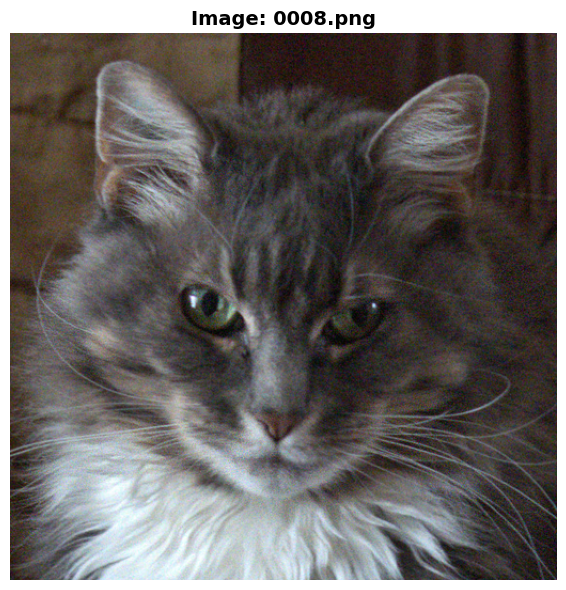

RF-Handcrafted       → cat        (Confidence: 63.61%)
SVM-Handcrafted      → cat        (Confidence: 100.00%)
RF-Deep              → cat        (Confidence: 93.33%)
SVM-Deep             → cat        (Confidence: 100.00%)

Image: 0008.png/n


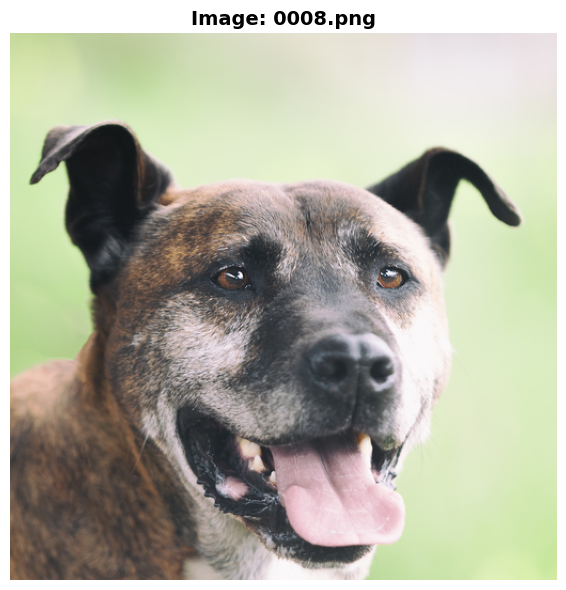

RF-Handcrafted       → dog        (Confidence: 56.86%)
SVM-Handcrafted      → dog        (Confidence: 98.98%)
RF-Deep              → dog        (Confidence: 90.00%)
SVM-Deep             → dog        (Confidence: 99.99%)

Image: 0008.png/n


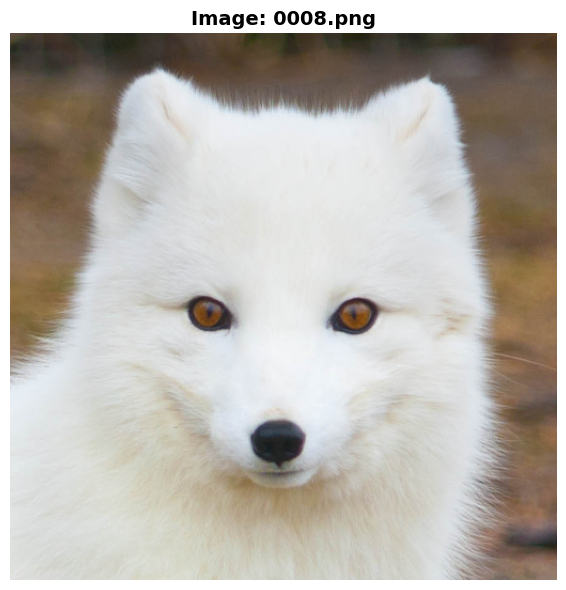

RF-Handcrafted       → cat        (Confidence: 41.41%)
SVM-Handcrafted      → wild       (Confidence: 45.29%)
RF-Deep              → wild       (Confidence: 61.01%)
SVM-Deep             → wild       (Confidence: 100.00%)



In [62]:
test_images = []
for label in labels:
    label_dir = os.path.join(TEST_DIR, label)
    imgs = [f for f in os.listdir(label_dir) if f.endswith(('.jpg', '.png'))]
    if imgs:
        test_images.append(os.path.join(label_dir, imgs[0]))

for img_path in test_images:
    predict_all_models(img_path)